In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
import numpy.random as rdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
%matplotlib inline

# TP3

## 1) Abeille et pesticides

In [364]:
df = pd.read_csv("./OrchardSprays.csv", index_col=0)

In [4]:
df.head()

,decrease,rowpos,colpos,treatment
1,57,1,1,D
2,95,2,1,E
3,8,3,1,B
4,69,4,1,H
5,92,5,1,G


In [5]:
df["treatment"] = df["treatment"].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 1 to 64
Data columns (total 4 columns):
decrease     64 non-null int64
rowpos       64 non-null int64
colpos       64 non-null int64
treatment    64 non-null category
dtypes: category(1), int64(3)
memory usage: 2.4 KB


In [6]:
df_tmp = df[['treatment', 'decrease']].sort_values(by=['treatment'])
df_tmp.head(n=5)

,treatment,decrease
14,A,2
19,A,5
26,A,4
63,A,3
53,A,4


TypeError: can only concatenate str (not "int") to str

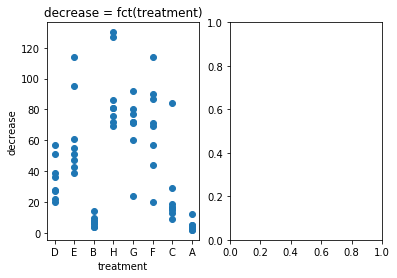

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(df["treatment"], df["decrease"])
ax[0].set_title("decrease = fct(treatment)")
ax[0].set_xlabel("treatment")
ax[0].set_ylabel("decrease")

#Multiple boxplot
df2 = df[['treatment', 'decrease']]
df2_tmp = []
treatLabs = list(df2['treatment'].unique())
for i in range(len(treatLabs)):
    df2_tmp.append(df2[['treatment','decrease']][df2['treatment'] == treatLabs[i]])

ax[1].boxplot(df_tmp)
ax[1].set_title("decrease = fct(treatment)")
ax[1].set_xlabel("treatment")
ax[1].set_ylabel("decrease")
;


In [8]:
df["treatment"].unique

<bound method Series.unique of 1     D
2     E
3     B
4     H
5     G
     ..
60    B
61    H
62    E
63    A
64    C
Name: treatment, Length: 64, dtype: category
Categories (8, object): [A, B, C, D, E, F, G, H]>

La variable "treatment" est composée de 8 modalités correspondants à 8 traitements différents. Pour savoir si la décroissance de fréquentation des abeilles est lié au traitement on peut utiliser un test de Fisher (Quanti/Quali) ou le modèle ANOVA. Le tableau de contingence ci-dessous permet de vérifier que le dispositif expérimental est équilibré.
On commence par réaliser un test de Fisher 

*NOTE : équilibré veut dire même effectif !"

In [9]:
df['decrease_cat']= pd.cut(df['decrease'],3, labels=['faible', 'moyen', 'eleve'])
ctTrDec = pd.crosstab(df['treatment'], df['decrease_cat'], margins = True)
round(ctTrDec/64,2)

decrease_cat,faible,moyen,eleve,All
treatment,,,,
A,0.12,0.00,0.00,0.12
B,0.12,0.00,0.00,0.12
C,0.11,0.02,0.00,0.12
D,0.09,0.03,0.00,0.12
E,0.03,0.06,0.03,0.12
F,0.03,0.06,0.03,0.12
G,0.02,0.09,0.02,0.12
H,0.00,0.09,0.03,0.12
All,0.53,0.36,0.11,1.00


In [10]:
#Test de Fisher
chi2, p, dof, exp = stats.chi2_contingency(ctTrDec)
print("La statistique de test = {0:.3f}, la p-valeur = {1:.3f}".format(chi2, p))

La statistique de test = 41.005, la p-valeur = 0.017


p < 0.05, on rejette "H0: les 2 variables sont indépendantes" au risque alpha=0.05. Les 2 variables sont liées. On aurait peut être pu essayer un test de Fisher. 

In [31]:
stat, pvalue = stats.f_oneway(
    df['decrease'][df['treatment']=='A'],
    df['decrease'][df['treatment']=='B'],
    df['decrease'][df['treatment']=='C']
)
print("La stat de test = {0:.3f}, la p valeur = {1:.3f}".format(stat, pvalue))

La stat de test = 4.823, la p valeur = 0.019


On décide donc de rejetter l'hypothèse nulle au risque 5%. Il existe donc une des moyennes qui est significativement différente des autres.

**Q4**
On vérifie les hypothèses :
    1. normalité des résidus
    2. indépendance des obs.
    3. homoscédasticité 
    

In [323]:
#Réalisation du modèle 

#idx_train = rdm.randint(0,len(df),size= round(len(df)*.7))
#idx_test = np.setxor1d(idx_train, np.arange(len(df)))
#X_train = df.iloc[idx_train,]
#X_test = df.iloc[idx_test, ]
df_tmp = df.copy()
df_tmp.drop('decrease', axis=1)
y = df['decrease']
X_train, X_test, y_train, y_test = train_test_split(df_tmp, y, test_size=0.3)
df_tmp2 = pd.concat([X_train, y_train], axis=1)

model = ols('decrease ~ treatment', data= X_train).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq      mean_sq          F        PR(>F)
treatment   7.0  43523.774675  6217.682096  14.022512  1.302857e-08
Residual   36.0  15962.657143   443.407143        NaN           NaN


Interprétation des résultats :

Normalité des résidus

''

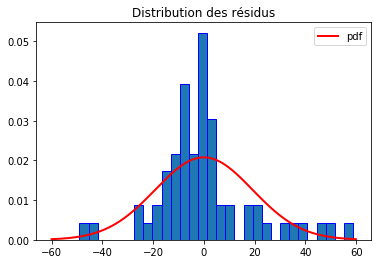

In [159]:
#ax, fig = plt.subplots()
import scipy.stats

residuals = df['decrease'] - model.predict(df)
x = np.arange(-60, 60,0.1)
fig , ax = plt.subplots()
ax.hist(residuals, bins = 30, density=True, edgecolor='b')
ax.plot(x, stats.norm.pdf(x, loc= np.mean(residuals), scale = np.std(residuals)), color='r', linewidth=2)
ax.set_title('Distribution des résidus')
ax.legend(['pdf'])
;

Vu le résultat graphique on décide de faire un test de shapiro Wilk

In [165]:
stat, p = stats.shapiro(residuals)
print('La stat de test = {0:.2f}, la p valeur = {1:.4f}'.format(stat, p))

La stat de test = 0.92, la p valeur = 0.0006


On rejette donc l'hypothèse nulle selon laquelle la distribution est normale

Vérification des hypothèses

Homoscédasticité
Pour test l'hypothèse d'homoscédasticité on utilise le test de Barlett.
H0: vA = vB = vC (toutes les variances sont égales)

In [412]:
df_tmp = []
df_tmp.append(df['decrease'][df['treatment']=='A'])
df_tmp.append(df['decrease'][df['treatment']=='B'])
df_tmp.append(df['decrease'][df['treatment']=='C'])
stats.bartlett(df_tmp[0], df_tmp[1], df_tmp[2])
print('La stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

print('var1= {0:.3f}, var2 {1:.3f}, var3 {2:.3f}'.format(df_tmp[0].std(), df_tmp[1].std(), df_tmp[2].std()))

La stat= 2.689, la pvaleur = 0.100
var1= 3.204, var2 3.292, var3 24.429


On rejette l'hypothèse H0. On se propose de faire une transformation pour obtenir la même variance

In [414]:
'''
#On réduit 
stdA = df_tmp[0].std()
stdB = df_tmp[1].std()
stdC = df_tmp[2].std()
#on réduit
df_tmp[0] = (df_tmp[0]/stdA)
df_tmp[1] = (df_tmp[1]/stdB)
df_tmp[2] = (df_tmp[2]/stdC)
stats.bartlett(df_tmp[0], df_tmp[1], df_tmp[2])
'''
for i in range(3):
    df_tmp[i] = pd.Series(map(math.log, df_tmp[i]))
    
    
stat , p = stats.bartlett(df_tmp[0], df_tmp[1], df_tmp[2])
print('La stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))
print('var1= {0:.3f}, var2 {1:.3f}, var3 {2:.3f}'.format(df_tmp[0].std(), df_tmp[1].std(), df_tmp[2].std()))


La stat= 4.632, la pvaleur = 0.099
var1= 0.436, var2 0.228, var3 0.207


Après cette transformation (non linéaire, on aurait aussi pu prendre racine carré). On note que l'on peut prendre n'importe quelle fonction bijective sur l'ensemble de définition. 
On peut refaire le test.


In [450]:
df_tmp = df.copy()
df_tmp.drop('decrease', axis=1)
y = df['decrease']
y = pd.Series(map(math.log, y))
X_train, X_test, y_train, y_test = train_test_split(df_tmp, y, test_size=0.3)
df_tmp2 = pd.concat([X_train, y_train], axis=1)

model = ols('decrease ~ treatment', data=df_tmp2).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq      mean_sq          F        PR(>F)
treatment   7.0  28615.966342  4087.995192  15.406266  3.931178e-09
Residual   36.0   9552.465476   265.346263        NaN           NaN


In [467]:
residuals = y_test - model.predict(X_test)
#residuals

In [443]:
#('A', 'B', 'C')
for i,j in [('A', 'B'), ('A', 'C'), ('B', 'C')]:
    stat, p = stats.ttest_ind(df['decrease'].loc[df['treatment'] == i], df['decrease'].loc[df['treatment'] == j])
    print('Test ({0}, {1}) : S= {2:.3f}, p = {3:.3f}'.format(i,j,stat,p))
    if p > 0.05:
        print('on rejette H0 au niveau 0.05 \n')
    else:
        print('on accepte H0 \n')

Test (A, B) : S= -1.847, p = 0.086
on rejette H0 au niveau 0.05 

Test (A, C) : S= -2.368, p = 0.033
on accepte H0 

Test (B, C) : S= -2.022, p = 0.063
on rejette H0 au niveau 0.05 



because the one-sided tests can be backed out from the two-sided tests. (With symmetric distributions one-sided p-value is just half of the two-sided pvalue)

La baisse moyenne du traitement B est différente des deux autres. Est-elle plus petite ou plus grande ? 

## 2 Volume pulmonaire


In [25]:
df_lung = pd.read_csv('lung.csv', index_col=0)
df_lung.head() #(18, 3)

,volume,method,subject
1,3.3,A,1
2,3.1,B,1
3,4.0,C,1
4,2.5,A,2
5,2.6,B,2


### Q1)
On dispose à nouveau d'un facteur et d'une variable quantitative. 
1er test statistique :
H0 : m_ind1 = ... m_ind6 où m désigne le volume pulmonaire moyen

In [6]:
df_tmp = []
for i in range(6):
    df_tmp.append(df_lung['volume'].loc[df_lung['subject']==i + 1])

In [7]:
stat, p = stats.f_oneway(df_tmp[0], df_tmp[1], df_tmp[2], df_tmp[3], df_tmp[4], df_tmp[5])
print('La stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

La stat= 2.738, la pvaleur = 0.071


On trouve une p-valeur >0.05, on ne rejette donc pas l'hypothèse H0 au risque de se tromper 5%. Les volumes moyen sont les mêmes pour les différents individus.

### Q2)
2nd test statistique :
H0 : m_A = m_B = m_C (les volumes pulmonaires moyens sont les mêmes selon les différents traitements)

In [8]:
df_tmp = [] #Liste de dataframes
for i in ['A', 'B', 'C']:
    df_tmp.append(df_lung['volume'].loc[df_lung['method']==i])

In [9]:
stat, p = stats.f_oneway(df_tmp[0], df_tmp[1], df_tmp[2])
print('La stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

La stat= 2.689, la pvaleur = 0.100


On ne rejette pas H0. Les volumes pulmonaires sont les mêmes selon les != traitements

### Q3)

Création d'un modèle ANOVA 2.

In [29]:
#Attention ! hyper important de transformer ces variables en variables qualitatives !
df_lung['method'] = df_lung['method'].astype('category')
df_lung['subject'] = df_lung['subject'].astype('category')

In [30]:
df_lung.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 1 to 18
Data columns (total 3 columns):
volume     18 non-null float64
method     18 non-null category
subject    18 non-null category
dtypes: category(2), float64(1)
memory usage: 636.0 bytes


In [31]:
#Attention, il ne faut pas faire de cv !
'''
y = df_lung['volume']
df_lung = df_lung.drop('volume', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_lung, y, test_size=0.3)
df_tmp = pd.concat([X_train, y_train], axis=1)
'''

"\ny = df_lung['volume']\ndf_lung = df_lung.drop('volume', axis=1)\nX_train, X_test, y_train, y_test = train_test_split(df_lung, y, test_size=0.3)\ndf_tmp = pd.concat([X_train, y_train], axis=1)\n"

In [32]:
#P-value for significance of adding model terms.
model = ols('volume ~ method + subject', data= df_lung).fit()
anova_table = sm.stats.anova_lm(model)
round(anova_table, 3)

,df,sum_sq,mean_sq,F,PR(>F)
method,2.0,1.081,0.541,6.495,0.016
subject,5.0,2.183,0.437,5.246,0.013
Residual,10.0,0.832,0.083,NaN,NaN


Les 2 premières questions montrent qu'en considérant chaque var quali séparément, on montre qu'il n'y a pas d'influence de ces variables sur la variable 'volume'. 
Cependant, dans la question 3, on considère les deux variables en même temps. On considère maintenant les deux variables et leurs intéractions. On rejette les hypothèses selon lesquelles chaque variable n'a pas d'influence sur le volume. Le modèle final se compose donc des deux variables ! 


## 3 Crabs

### 1)

In [35]:
# body depth BD en fonction des facteurs sexe et espèce.
df_crabs = pd.read_csv('crabs.csv', index_col=0, dtype={'sex':'category', 'sp':'category'})
df_crabs

,sp,sex,index,FL,RW,CL,CW,BD
1,B,M,1,8.1,6.7,16.1,19.0,7.0
2,B,M,2,8.8,7.7,18.1,20.8,7.4
3,B,M,3,9.2,7.8,19.0,22.4,7.7
4,B,M,4,9.6,7.9,20.1,23.1,8.2
5,B,M,5,9.8,8.0,20.3,23.0,8.2
...,...,...,...,...,...,...,...,...
196,O,F,46,21.4,18.0,41.2,46.2,18.7
197,O,F,47,21.7,17.1,41.7,47.2,19.6
198,O,F,48,21.9,17.2,42.6,47.4,19.5
199,O,F,49,22.5,17.2,43.0,48.7,19.8


In [37]:
df_crabs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 8 columns):
sp       200 non-null category
sex      200 non-null category
index    200 non-null int64
FL       200 non-null float64
RW       200 non-null float64
CL       200 non-null float64
CW       200 non-null float64
BD       200 non-null float64
dtypes: category(2), float64(5), int64(1)
memory usage: 11.4 KB


''

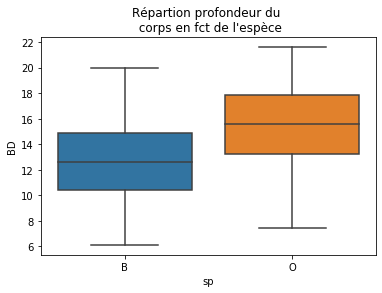

In [55]:
fig , ax = plt.subplots()
sns.boxplot(x='sp', y='BD', data= df_crabs)
ax.set_title('Répartion profondeur du \n corps en fct de l\'espèce')
;

''

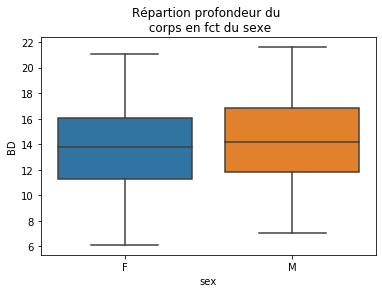

In [60]:
fig , ax = plt.subplots()
sns.boxplot(x='sex', y='BD', data= df_crabs)
ax.set_title('Répartion profondeur du \n corps en fct du sexe')
;

In [63]:
#P-value for significance of adding model terms.
model_sex = ols('BD ~ sex', data= df_crabs).fit()
anova_table = sm.stats.anova_lm(model_sex)
round(anova_table, 3)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,18.788,18.788,1.607,0.206
Residual,198.0,2315.295,11.693,NaN,NaN


On ne rejette pas H0, la variable sexe n'a pas d'influence sur la prof. du corps si on considère uniquement la variable sexe. 

In [65]:
model_sp = ols('BD ~ sp', data= df_crabs).fit()
anova_table = sm.stats.anova_lm(model_sp)
round(anova_table, 4)

,df,sum_sq,mean_sq,F,PR(>F)
sp,1.0,419.0512,419.0512,43.3268,0.0
Residual,198.0,1915.0327,9.6719,NaN,NaN


On rejette H0. Forte influence de l'espèce, que l'on voit d'ailleurs très bien sur le boxplot.

Vérification des hypothèses :

**Normalité des résidus**

''

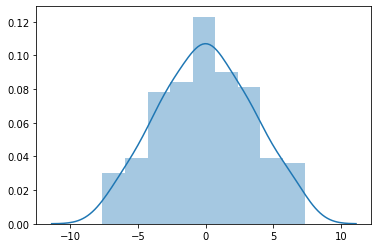

In [72]:
res_sex = df_crabs['BD'] - model_sex.predict(df_crabs)
sns.distplot(res_sex)
;

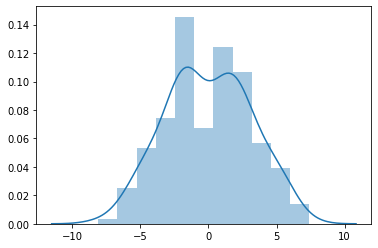

In [75]:
res_sp = df_crabs['BD'] - model_sp.predict(df_crabs)
sns.distplot(res_sp);

In [91]:
stat, p = stats.shapiro(res_sex)
print('Test Shapiro sex: la stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

Test Shapiro sex: la stat= 0.990, la pvaleur = 0.200


On a bien la gaussianité des résidus pour sex

In [92]:
stat, p = stats.shapiro(res_sp)
print('Test Shapiro sex: la stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

Test Shapiro sex: la stat= 0.990, la pvaleur = 0.169


Même chose pour la variable sp !

**Homoscédasticité**

Test de Bartlett

Pour la variable sex

In [95]:
df_tmp = []
df_tmp.append(df_crabs['BD'][df_crabs['sex']=='M'])
df_tmp.append(df_crabs['BD'][df_crabs['sex']=='F'])
stats.bartlett(df_tmp[0], df_tmp[1])
print('La stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

print('var1= {0:.3f}, var2 {1:.3f}'.format(df_tmp[0].std(), df_tmp[1].std()))

La stat= 0.990, la pvaleur = 0.169
var1= 3.494, var2 3.343


La condition d'homoscédasticité est vérifiée pour sex.
Pour la variable sp :

In [98]:
df_tmp = []
df_tmp.append(df_crabs['BD'][df_crabs['sp']=='B'])
df_tmp.append(df_crabs['BD'][df_crabs['sp']=='O'])
stats.bartlett(df_tmp[0], df_tmp[1])
print('La stat= {0:.3f}, la pvaleur = {1:.3f}'.format(stat,p))

print('var1= {0:.3f}, var2 {1:.3f}'.format(df_tmp[0].std(), df_tmp[1].std()))

La stat= 0.990, la pvaleur = 0.169
var1= 3.068, var2 3.151


Même chose pour sp

### Q2)

Construction ANOVA 2

In [99]:
model = ols('BD ~ sex + sp + sex :sp', data=df_crabs).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df      sum_sq     mean_sq          F        PR(>F)
sex         1.0    18.78845   18.788450   1.986445  1.602977e-01
sp          1.0   419.05125  419.051250  44.305005  2.751275e-10
sex:sp      1.0    42.41205   42.412050   4.484096  3.547225e-02
Residual  196.0  1853.83220    9.458328        NaN           NaN


Influence du sex mais à travers l'intéraction des 2 variables.
Une esp, les mâles sont un peu plus gros. C'est l'inverse pour l'autre sp. 
Donc pas d'influence du sexe tout seul, mais quand on considère l'interraction des deux variables on trouve une influence du sexe !
Il est donc très important de considérer l'ANOVA2 plutôt que 2 ANOVA1. 

In [100]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BD   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     16.93
Date:                Tue, 21 Jan 2020   Prob (F-statistic):           8.13e-10
Time:                        11:08:15   Log-Likelihood:                -506.46
No. Observations:                 200   AIC:                             1021.
Df Residuals:                     196   BIC:                             1034.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.8160      0.435     27.167      0.000      10.958      12.674
sex[T.M]             1.5340      0.615      2.494      0.013       0.321       2.747
sp[T.O]              3.8160      0.615      6.204      0.000       2.603       5.029
sex[T.M]:sp[T.O]    -1.8420      0.870     -2.118      0.035      -3.557      -0.127
==============================================================================
Omnibus:                        5.153   Durbin-Watson:                   0.332
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                3.009
Skew:                          -0.046   Prob(JB):                        0.222
Kurtosis:                       2.406   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""